In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xgb
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", 500)

In [2]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep parquet

216M -rw-r--r-- 1 nobody 216M Mar 28 17:53 Combined_Flights_2018.parquet
295M -rw-r--r-- 1 nobody 295M Mar 28 17:53 Combined_Flights_2019.parquet
175M -rw-r--r-- 1 nobody 175M Mar 28 17:53 Combined_Flights_2020.parquet
232M -rw-r--r-- 1 nobody 232M Mar 28 17:53 Combined_Flights_2021.parquet
143M -rw-r--r-- 1 nobody 143M Mar 28 17:53 Combined_Flights_2022.parquet


In [3]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep csv

 40K -rw-r--r-- 1 nobody  39K Mar 28 17:52 Airlines.csv
1.9G -rw-r--r-- 1 nobody 1.9G Mar 28 17:55 Combined_Flights_2018.csv
2.7G -rw-r--r-- 1 nobody 2.7G Mar 28 17:55 Combined_Flights_2019.csv
1.7G -rw-r--r-- 1 nobody 1.7G Mar 28 17:54 Combined_Flights_2020.csv
2.1G -rw-r--r-- 1 nobody 2.1G Mar 28 17:55 Combined_Flights_2021.csv
1.4G -rw-r--r-- 1 nobody 1.4G Mar 28 17:54 Combined_Flights_2022.csv


In [4]:
print(xgb.__version__)  # Должна быть версия ≥1.5.0
print(xgb.build_info()["USE_CUDA"])  # Должно быть 'ON'

1.6.2
True


# Read in and Format Data

In [5]:
def get_time_category(deptime):
    # Преобразуем время в строку и добавляем ведущий ноль, если необходимо
    time_str = f"{int(deptime):04}"
    hours = int(time_str[:2])
    minutes = int(time_str[2:])
    
    if 6 <= hours < 12:
        return "Morning"
    elif 12 <= hours < 18:
        return "Day"
    elif 18 <= hours < 24:
        return "Evening"
    else:
        return "Night"

def target_encode(train_df, valid_df, test_df, column, target):
    # Вычисляем среднее значение целевой переменной для каждой категории в обучающей выборке
    mean_target = train_df.groupby(column)[target].mean()
    
    # Применяем кодирование к обучающей и тестовой выборкам
    train_df[column] = train_df[column].map(mean_target)
    test_df[column] = test_df[column].map(mean_target)
    valid_df[column] = valid_df[column].map(mean_target)
    
    # Заполняем пропуски (если есть категории, которые не встречались в обучающей выборке)
    train_df[column].fillna(train_df[target].mean(), inplace=True)
    test_df[column].fillna(train_df[target].mean(), inplace=True)
    valid_df[column].fillna(train_df[target].mean(), inplace=True)
    
    return train_df, valid_df, test_df, 

# Plot the confusion matrix for the test set
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [6]:
parquet_files = glob("../input/flight-delay-dataset-20182022/*.parquet")

In [7]:
column_subset = ["Flight_Number_Marketing_Airline", 'Month', 'DayOfWeek', 'DayofMonth', 'DOT_ID_Operating_Airline','Distance',
          'DistanceGroup', 'DestAirportSeqID','CRSDepTime', 'IATA_Code_Operating_Airline',
          'Airline', 'OriginAirportID', 'DestCityName', 'DestAirportID', 'Diverted', 'Cancelled',
          'IATA_Code_Marketing_Airline', 'DepDelayMinutes']

dfs = []
for f in parquet_files:
    dfs.append(pd.read_parquet(f, columns=column_subset))
df = pd.concat(dfs).reset_index(drop=True)

In [8]:
df = df[df['Cancelled'] == False]

In [9]:
df = df[df['CRSDepTime'].isna() == False]

df['daytime'] = df['CRSDepTime'].apply(get_time_category)

cat_cols = ['DOT_ID_Operating_Airline', 'Airline', 'OriginAirportID','DistanceGroup', 'IATA_Code_Operating_Airline',
                'DestCityName', 'DestAirportID','IATA_Code_Marketing_Airline', 'daytime']

for c in df.columns:
    print(df[c].isna().value_counts(), end='\n\n')

False    28416515
Name: Flight_Number_Marketing_Airline, dtype: int64

False    28416515
Name: Month, dtype: int64

False    28416515
Name: DayOfWeek, dtype: int64

False    28416515
Name: DayofMonth, dtype: int64

False    28416515
Name: DOT_ID_Operating_Airline, dtype: int64

False    28416515
Name: Distance, dtype: int64

False    28416515
Name: DistanceGroup, dtype: int64

False    28416515
Name: DestAirportSeqID, dtype: int64

False    28416515
Name: CRSDepTime, dtype: int64

False    28416515
Name: IATA_Code_Operating_Airline, dtype: int64

False    28416515
Name: Airline, dtype: int64

False    28416515
Name: OriginAirportID, dtype: int64

False    28416515
Name: DestCityName, dtype: int64

False    28416515
Name: DestAirportID, dtype: int64

False    28416515
Name: Diverted, dtype: int64

False    28416515
Name: Cancelled, dtype: int64

False    28416515
Name: IATA_Code_Marketing_Airline, dtype: int64

False    28415402
True         1113
Name: DepDelayMinutes, dtype: int64

Fal

**Dropping samples with Nan values.**

In [10]:
df.dropna(how='any', inplace=True)

In [11]:
df.drop('Cancelled', axis=1, inplace=True)

**Matching each sample to the delay group.**

In [12]:
df["DelayGroup"] = None

df.loc[df["DepDelayMinutes"] == 0, "DelayGroup"] = "OnTime_Early"

df.loc[
    (df["DepDelayMinutes"] > 0) & (df["DepDelayMinutes"] <= 120), "DelayGroup"
] = "Small_Delay"

df.loc[
    (df["DepDelayMinutes"] > 120) & (df["DepDelayMinutes"] <= 240), "DelayGroup"
] = "Medium_Delay"

df.loc[
(df["DepDelayMinutes"] > 240) & (df["DepDelayMinutes"] <= 480), "DelayGroup"] = "Large_Delay"

df.loc[df["DepDelayMinutes"] > 480, "DelayGroup"] = "Very_Large_Delay"

**Lets encode target variable**

In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['DelayGroup'] = encoder.fit_transform(df['DelayGroup'])

In [14]:
print("Categories:", encoder.classes_)
print("Matching:", dict(zip(encoder.classes_, range(len(encoder.classes_)))))

Categories: ['Large_Delay' 'Medium_Delay' 'OnTime_Early' 'Small_Delay'
 'Very_Large_Delay']
Matching: {'Large_Delay': 0, 'Medium_Delay': 1, 'OnTime_Early': 2, 'Small_Delay': 3, 'Very_Large_Delay': 4}


In [15]:
df['DelayGroup'].value_counts()

2    19240509
3     8518144
1      495912
0      122096
4       38741
Name: DelayGroup, dtype: int64

In [16]:
df.to_parquet('data.parquet', engine='pyarrow')

In [17]:
X = df[['Month', 'DayOfWeek', 'DayofMonth', 'DOT_ID_Operating_Airline', 'Distance',
          'DistanceGroup', 'DestAirportSeqID', 'daytime', 'DepDelayMinutes',
          'Airline', 'OriginAirportID', 'DestCityName', 'DestAirportID', 'Diverted',
          'IATA_Code_Operating_Airline', 'IATA_Code_Marketing_Airline']]
y = df['DelayGroup']



**Split data on train, validation and test sets.**

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      stratify=y_train, 
                                                      test_size=0.2, 
                                                      random_state=42)

**Using target encoder to encode categorical features.**

In [19]:
X_train_enc, X_valid_enc, X_test_enc = X_train, X_valid, X_test

for col in cat_cols:
    X_train_enc, X_valid_enc, X_test_enc = target_encode(X_train, X_valid, X_test, col, 
                                                         'DepDelayMinutes')
X_train_enc.drop('DepDelayMinutes', axis=1, inplace=True)
X_valid_enc.drop('DepDelayMinutes', axis=1, inplace=True)
X_test_enc.drop('DepDelayMinutes', axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer, f1_score




def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate',0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'tree_method': 'gpu_hist',  # Использование GPU
        'gpu_id': 0,
        'eval_metric': 'mlogloss',
        'predictor': 'gpu_predictor',
        'random_state': 42
    }
    sample_weights = compute_sample_weight('balanced', y_train)
    
    model = XGBClassifier(**params)
    scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_enc, y_train, cv=3,
                             fit_params={'sample_weight': sample_weights},
                             scoring=scorer)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Лучшие параметры:", study.best_params)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

model = XGBClassifier(**{'max_depth': 10, 
                        'learning_rate': 0.11561259277004979, 
                        'subsample': 0.8869936342562553, 
                        'colsample_bytree': 0.9271078439145526, 
                        'n_estimators': 3000,
                        'tree_method': 'gpu_hist',
                        'gpu_id': 0,
                        'eval_metric': 'mlogloss',
                        'predictor': 'gpu_predictor',
                        'random_state': 42})

sample_weights = compute_sample_weight('balanced', y_train)
model.fit(X_train_enc, y_train, sample_weight=sample_weights, eval_set=[(X_valid_enc, y_valid)])


Validation Accuracy: 0.5782
              precision    recall  f1-score   support

           0       0.02      0.17      0.03     19535
           1       0.05      0.34      0.09     79346
           2       0.81      0.63      0.71   3078482
           3       0.47      0.49      0.48   1362903
           4       0.01      0.08      0.02      6199

    accuracy                           0.58   4546465
   macro avg       0.27      0.34      0.27   4546465
weighted avg       0.69      0.58      0.62   4546465

Test Accuracy: 0.5782
              precision    recall  f1-score   support

           0       0.02      0.17      0.03     24419
           1       0.05      0.34      0.09     99183
           2       0.81      0.63      0.71   3848102
           3       0.47      0.49      0.48   1703629
           4       0.01      0.09      0.02      7748

    accuracy                           0.58   5683081
   macro avg       0.27      0.34      0.27   5683081
weighted avg       0.69    

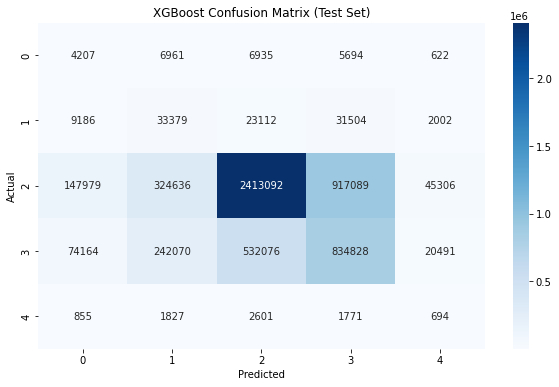

In [21]:
y_val_pred = model.predict(X_valid_enc)
val_accuracy = accuracy_score(y_valid, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_valid, y_val_pred))

# Predict on the test set
y_test_pred = model.predict(X_test_enc)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(y_test, y_test_pred, title='XGBoost Confusion Matrix (Test Set)')

In [22]:
with open('xgb_model_1.pkl', 'wb') as f:
    pickle.dump(model, f)

In [26]:
prev_len = 0
y_train_list = list(y_train[:2264])

index_0 = y_train_list.index(0)
index_1 = y_train_list.index(1)
index_2 = y_train_list.index(2)
index_3 = y_train_list.index(3)
index_4 = y_train_list.index(4)



In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      stratify=y_train, 
                                                      test_size=0.2, 
                                                      random_state=42)


,Month,DayOfWeek,DayofMonth,DOT_ID_Operating_Airline,Distance,DistanceGroup,DestAirportSeqID,daytime,DepDelayMinutes,Airline,OriginAirportID,DestCityName,DestAirportID,Diverted,IATA_Code_Operating_Airline,IATA_Code_Marketing_Airline
3132507,1,1,24,19393,925.0,4,1082106,Morning,0.0,Southwest Airlines Co.,11697,"Baltimore, MD",10821,False,WN,WN
2054118,5,2,10,19790,488.0,2,1143302,Day,45.0,Delta Air Lines Inc.,11618,"Detroit, MI",11433,False,DL,DL
6504857,9,5,17,19805,868.0,4,1410702,Day,4.0,American Airlines Inc.,11298,"Phoenix, AZ",14107,False,AA,AA
556799,4,6,2,19977,524.0,3,1084907,Evening,0.0,United Air Lines Inc.,11292,"Bozeman, MT",10849,False,UA,UA
6964884,1,3,6,20304,545.0,3,1227805,Evening,0.0,SkyWest Airlines Inc.,13487,"Wichita, KS",12278,False,OO,DL


In [81]:
user_data = X_train[:2264]

In [82]:
user_data = user_data.reset_index().loc[[index_0, index_1, index_2, index_3, index_4]]
user_data.drop('index', axis=1, inplace=True)

In [83]:
user_data['flight_number'] = [x for x in range(5)]
user_data = user_data[['flight_number'] + list(user_data.columns)[:-1]]
user_data

,flight_number,Month,DayOfWeek,DayofMonth,DOT_ID_Operating_Airline,Distance,DistanceGroup,DestAirportSeqID,daytime,DepDelayMinutes,Airline,OriginAirportID,DestCityName,DestAirportID,Diverted,IATA_Code_Operating_Airline,IATA_Code_Marketing_Airline
53,0,8,2,24,19977,296.0,2,1393007,Evening,302.0,United Air Lines Inc.,11066,"Chicago, IL",13930,False,UA,UA
205,1,7,3,31,20397,318.0,2,1127805,Day,154.0,Comair Inc.,10257,"Washington, DC",11278,False,OH,AA
0,2,1,1,24,19393,925.0,4,1082106,Morning,0.0,Southwest Airlines Co.,11697,"Baltimore, MD",10821,False,WN,WN
1,3,5,2,10,19790,488.0,2,1143302,Day,45.0,Delta Air Lines Inc.,11618,"Detroit, MI",11433,False,DL,DL
2263,4,12,1,9,20304,373.0,2,1489302,Evening,770.0,SkyWest Airlines Inc.,12892,"Sacramento, CA",14893,False,OO,UA


In [84]:
user_data.to_parquet('user_data.parquet', engine='pyarrow')

In [106]:
model_data = X_train_enc[:2264]
model_data = model_data.iloc[[index_0, index_1, index_2, index_3, index_4]]
model_data = model_data.reset_index().drop(['index'], axis=1)

In [104]:
model_data.to_parquet('model_data.parquet', engine='pyarrow')

In [107]:
model_data

,Month,DayOfWeek,DayofMonth,DOT_ID_Operating_Airline,Distance,DistanceGroup,DestAirportSeqID,daytime,Airline,OriginAirportID,DestCityName,DestAirportID,Diverted,IATA_Code_Operating_Airline,IATA_Code_Marketing_Airline
0,8,2,24,13.674422,296.0,12.183798,1393007,18.082740,13.674422,11.565308,14.666765,15.559894,False,13.674422,14.949594
1,7,3,31,12.670189,318.0,12.183798,1127805,14.288710,12.670189,13.338724,13.196439,12.998076,False,12.670189,12.896031
2,1,1,24,11.859741,925.0,13.205926,1082106,8.684606,11.859741,15.436103,10.839956,10.839956,False,11.859741,11.859741
3,5,2,10,9.581869,488.0,12.183798,1143302,14.288710,9.581869,19.085981,11.708309,11.708309,False,9.581869,10.576608
4,12,1,9,13.850727,373.0,12.183798,1489302,18.082740,13.850727,11.471753,10.996511,10.996511,False,13.850727,14.949594
